In [60]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize, fsolve
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

In [19]:
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt

# Parameters
alpha = 3
C = 1

# Exponents for the Beta functions
p = (alpha - 1)/alpha  # = 2/3
q = (alpha + 1)/alpha  # = 4/3

# Complete Beta function B(p,q)
B_pq = mp.betainc(p, q, 0, 1)  # This is the full Beta integral from 0 to 1

def I(b):
    """
    I(b) = ∫[z=b..∞] [z^(-alpha) / (z^(-alpha) + C)^2] dz.
    For alpha=3, C=1, it becomes (1/3)[B(2/3,4/3) - B_x(2/3,4/3)].
    """
    # x = C / (b^(-alpha) + C) = 1 / (b^(-3) + 1)
    x = C/(b**(-alpha) + C)
    
    # Lower incomplete Beta function B_x(p,q) = ∫[t=0..x] t^(p-1)*(1-t)^(q-1) dt
    Bx_pq = mp.betainc(p, q, 0, x)  # lower incomplete Beta from 0 to x
    
    return (C**(1/alpha - 1)/alpha)*(B_pq - Bx_pq)

# We'll sample b on a log-spaced or linear-spaced grid:
b_vals = np.linspace(0.01, 10, 200)  # from b=0.01 to b=10
I_vals = [I(b) for b in b_vals]

In [20]:
def allo(b):
    return b**(-alpha) / (C + b**(-alpha))

In [21]:
allos = [allo(b) for b in b_vals]

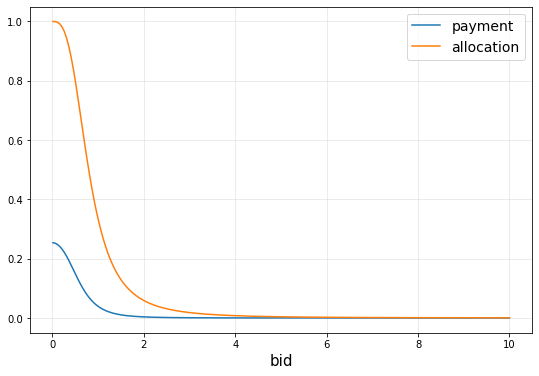

In [18]:
f, ax = plt.subplots(figsize=(9,6))

ax.plot(b_vals, I_vals, label=r'payment')
ax.plot(b_vals, allos, label=r'allocation')


ax.set_xlabel(r'bid', size=15)
ax.legend(fontsize=14)
ax.grid(alpha=0.3)

plt.show()

In [43]:
def integral_z_alpha(alpha, C, b):
    """
    Computes the definite integral:
    I(alpha, C, b) = ∫[z=b..∞] z^(-alpha) / (z^(-alpha) + C)^2 dz
    
    Parameters:
    -----------
    alpha : float > 0
    C     : float > 0
    b     : float > 0
    
    Returns:
    --------
    Value of the integral as a float.
    """
    # Define p and q for the Beta functions
    p = (alpha - 1) / alpha
    q = (alpha + 1) / alpha
    
    # Complete Beta function B(p,q)
    # mpmath.betainc(p, q, 0, 1) gives the integral from 0 to 1
    B_pq = mp.betainc(p, q, 0, 1)
    
    # Lower incomplete Beta function:
    # betainc(p, q, 0, x) corresponds to ∫[0..x] t^(p-1)*(1-t)^(q-1) dt
    x = C / (b**(-alpha) + C)
    Bx_pq = mp.betainc(p, q, 0, x)
    
    # Combine everything according to the closed-form expression
    factor = -C**(1/alpha) 
    return factor * (B_pq - Bx_pq)

def allo(alpha, C, b):
    return b**(-alpha) / (C + b**(-alpha))

In [44]:
b_vals = np.linspace(0.01, 10, 200)  
Cs     = [0.1, 1, 10]
alpha  = 3

payments = []
allos    = []
for C in Cs:
    payments.append([integral_z_alpha(alpha, C, b) for b in b_vals])
    allos.append([allo(alpha, C, b) for b in b_vals])
payments = np.array(payments)
allos    = np.array(allos)
payments.shape, allos.shape

((3, 200), (3, 200))

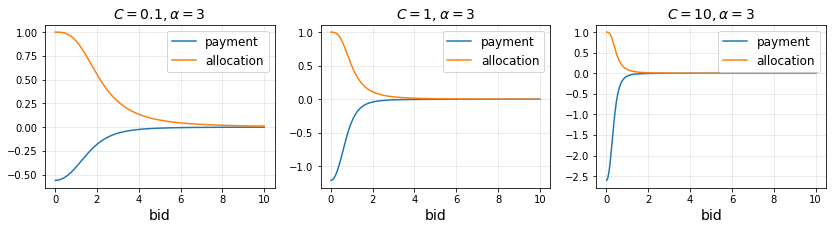

In [46]:
f, axarr = plt.subplots(ncols=3, figsize=(14,3))


for i, ax in enumerate(axarr):
    ax.plot(b_vals, payments[i], label=r'payment')
    ax.plot(b_vals, allos[i], label=r'allocation')

    ax.set_xlabel(r'bid', size=14)
    ax.legend(fontsize=12)
    ax.grid(alpha=0.3)
    ax.set_title(r'$C={}, \alpha=3$'.format(Cs[i]), size=14)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# optimization

In [56]:
def F(x, c, alpha):
    vals  = np.array([c[i]*np.power(x[i], 1+1/alpha) for i in range(len(c))])
    return np.sum(vals)

In [62]:
def Theos(c, alpha):
    den = sum(np.power(c, -alpha))
    return np.power(c, -alpha)/den

In [77]:
c = np.array([1,10,4,3])
alpha = 3.

In [78]:
start_pos = [1/len(c) for i in range(len(c))]
cons = ({'type': 'eq', 'fun': lambda x:  1 - sum(x)})
bnds = tuple((0,1) for x in start_pos)

res = minimize(
    F, 
    start_pos, 
    method      = 'SLSQP',
    args        = (c, alpha),
    bounds      = bnds, 
    constraints = cons, 
    tol=1e-16
)
res

     fun: 0.9827270017283498
     jac: array([1.31030267, 1.31030309, 1.31030267, 1.31030268])
 message: 'Optimization terminated successfully'
    nfev: 153
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([9.49070941e-01, 9.49064375e-04, 1.48292259e-02, 3.51507689e-02])

In [79]:
Theos(c, alpha=3.)

array([0.94907092, 0.00094907, 0.01482923, 0.03515077])

# optimization with a capped constraint.

In [80]:
def F(x, c, alpha):
    vals  = np.array([c[i]*np.power(x[i], 1+1/alpha) for i in range(len(c))])
    return np.sum(vals)

In [104]:
def solve_constrained(c, alpha):
    """
    Solve:
        min sum_j c[j]* (x[j])^(1+1/alpha)
        s.t. sum_j x[j] = 1,  0 <= x[j] <= 1 - 1/alpha.
    Returns: x (array)
    """
    n = len(c)
    c = np.array(c, dtype=float)  # ensure floats
    
    # Quick feasibility check
    if n * (1 - 1/alpha) < 1.0:
        raise ValueError("Infeasible: not enough 'room' to sum to 1.")
    
    # We'll store the final x in x_sol
    x_sol = np.zeros(n, dtype=float)
    
    # Set of indices not yet clamped:
    active = list(range(n))
    
    # How much "mass" is left to allocate
    mass_left = 1.0
    
    # While we still have variables to solve for:
    while len(active) > 0:
        
        # Among the active set, compute denominators
        c_inv_alpha = np.power(c[active], -alpha)
        denom = np.sum(c_inv_alpha)
        
        # Proposed unconstrained solution for each j in active
        x_u = (c_inv_alpha / denom) * mass_left
        
        # Check if we need to clamp any x_u[j]
        too_big = [j for (j, val) in zip(active, x_u) if val > (1 - 1/alpha)]
        
        if len(too_big) == 0:
            # None of them violate the upper bound => we are done
            for (j, val) in zip(active, x_u):
                x_sol[j] = val
            break
        else:
            # At least one violates => clamp them
            for j in too_big:
                x_sol[j] = 1 - 1/alpha
            # So we remove those from the active set
            # and reduce the mass_left accordingly
            for j in too_big:
                active.remove(j)
                mass_left -= (1 - 1/alpha)
                
            # If mass_left < 1e-15 or so, we might be effectively done
            # but let's continue if needed

    return x_sol

In [126]:
c = np.array([1,2,3,4,5])
alpha = 4/3

In [127]:
start_pos = [1/len(c) for i in range(len(c))]
cons = ({'type': 'eq', 'fun': lambda x:  1 - sum(x)})

# MODIFY THE BNDS
bnds = tuple((0,1-1/alpha) for x in start_pos)

res = minimize(
    F, 
    start_pos, 
    method      = 'SLSQP',
    args        = (c, alpha),
    bounds      = bnds, 
    constraints = cons, 
    tol=1e-16
)
res

     fun: 0.761026920667263
     jac: array([0.61871842, 1.23743684, 1.73551665, 1.73551662, 1.73551662])
 message: 'Optimization terminated successfully'
    nfev: 168
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([0.25      , 0.25      , 0.22857354, 0.15575463, 0.11567183])

In [128]:
solve_constrained(c, alpha=alpha)

array([0.25      , 0.25      , 0.22857354, 0.15575463, 0.11567183])

In [129]:
Theos(c, alpha)

array([0.52564586, 0.2086027 , 0.12148749, 0.08278404, 0.06147991])

In [132]:
Theos(c[1:], alpha) * 0.75

array([0.32982114, 0.19208354, 0.13088961, 0.09720572])

In [133]:
Theos(c[2:], alpha) * 0.5

array([0.22857354, 0.15575463, 0.11567183])